# Gated Reccurent Unit (GRU)

### Introduction
LSTM’s and GRU’s were created as a method to mitigate short-term memory using mechanisms called gates. Gates are just neural networks that regulate the flow of information flowing through the sequence chain.

![alt text](gru_cell.png "GRU")

### Model Structure
![alt text](struc.png "Model Structure")

### Inputs
- j1_ptrel # ratio of the pT of each constituent to the pT of the jet
- j1_etarol # roated eta of each constituent
- j1_phirot # roated phi of each constituent
- j1_erel # ratio of the energy of each constituent to the pT of the jet
- j1_deltaR # sqrt(($\Delta$ eta)^2 + ($\Delta$phi)^2)
- j1_pdgid # PDF ID number of the constituent
- j1_index # dropped during training

### Labels
- j_g # gloun jet
- j_q # light_quark jet
- j_w # W-boson
- j_z # Z-boson
- j_t # top-quark
- j1_index # dropped in training

![alt text](struc2.png "Model Structure")

This model will converge too early and will provide unsatisfactory results. To deal with this, we need more features and more complex model.

### Multilayer GRU
Inputs (22)
- 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 
- 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2': Energy Correlation Function
- 'j_mass': jet mass 
- 'j_multiplicity': number of constituents
- 'j_zlogz': Jet splitting fraction
- 'j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_pdgid','j_index': Original features


### Model Structure
Simply add a GRU layer with 32 units and keep all other configurations the same.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Dropout
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [3]:
# To use one data file:
h5File = h5py.File('processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = h5File['t_allpar_new'][()]

h5File.close()

print(treeArray.shape)

# List of features to use
features = ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_pdgid', 'j_index']

# List of labels to use
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

# Convert to dataframe
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]
labels_df = labels_df.drop_duplicates()

# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values     

if 'j_index' in features:
    features_val = features_val[:,:-1] # drop the j_index feature
if 'j_index' in labels:
    labels_val = labels_val[:,:-1] # drop the j_index label
    print(labels_val.shape)

(5131613,)
(98769, 5)


In [4]:
MaxParticles = 20
features_2dval = np.zeros((len(labels_df), MaxParticles, len(features)-1))
for i in tqdm(range(0, len(labels_df))):
    features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values
    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]] # sort descending by ptrel
    if nParticles > MaxParticles:
        features_val_i =  features_val_i[0:MaxParticles, :]
    else:        
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles-nParticles, len(features)-1))])
    features_2dval[i, :, :] = features_val_i
features_val = features_2dval

100%|██████████| 98769/98769 [19:00<00:00, 86.58it/s]  


In [5]:
X_train, X_test, y_train, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [6]:
#Normalize conv inputs
reshape_X_train_val = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train.shape[1]):
    X_train[:,p,:] = scaler.transform(X_train[:, p, :])
    X_test[:,p,:] = scaler.transform(X_test[:, p, :])    

if 'j_index' in labels:
    labels = labels[:-1]

### Exercise
Given this model structure that is also described above, try constructing the network.
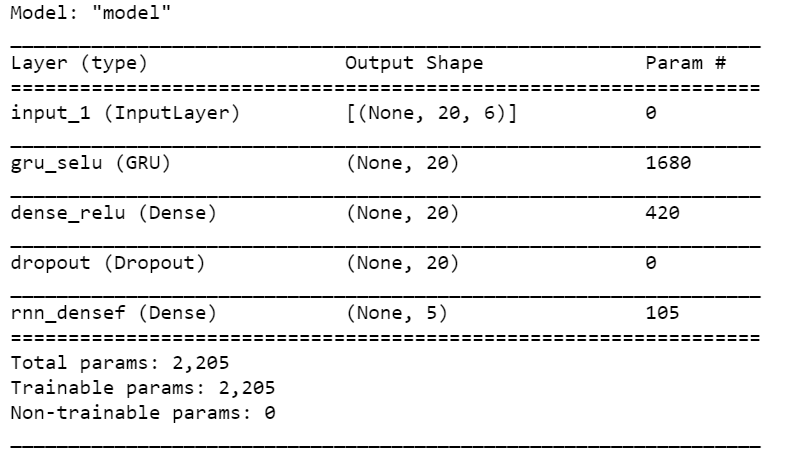

In [2]:
# Make the network here. Values for the regularizers are given. Results are given for comparison in the cells below
l1Reg =  0.0001
l1RegR = 0.001



In [8]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(X_train, y_train, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 19s 10ms/step - loss: 1.2046 - accuracy: 0.5557 - val_loss: 1.0243 - val_accuracy: 0.6450
Epoch 2/100
1852/1852 [==============================] - 18s 10ms/step - loss: 1.0133 - accuracy: 0.6548 - val_loss: 0.9574 - val_accuracy: 0.6715
Epoch 3/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.9648 - accuracy: 0.6742 - val_loss: 0.9313 - val_accuracy: 0.6863
Epoch 4/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.9455 - accuracy: 0.6801 - val_loss: 0.9169 - val_accuracy: 0.6896
Epoch 5/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.9318 - accuracy: 0.6859 - val_loss: 0.9137 - val_accuracy: 0.6869
Epoch 6/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.9236 - accuracy: 0.6890 - val_loss: 0.8949 - val_accuracy: 0.6987
Epoch 7/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.9141 - accuracy: 0.6912 - val_loss: 0.8863

Epoch 57/100
1852/1852 [==============================] - 16s 9ms/step - loss: 0.8433 - accuracy: 0.7157 - val_loss: 0.8190 - val_accuracy: 0.7216
Epoch 58/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.8449 - accuracy: 0.7156 - val_loss: 0.8227 - val_accuracy: 0.7209
Epoch 59/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.8429 - accuracy: 0.7171 - val_loss: 0.8216 - val_accuracy: 0.7209
Epoch 60/100
1852/1852 [==============================] - 18s 10ms/step - loss: 0.8463 - accuracy: 0.7132 - val_loss: 0.8248 - val_accuracy: 0.7240
Epoch 61/100
1852/1852 [==============================] - 18s 10ms/step - loss: 0.8440 - accuracy: 0.7163 - val_loss: 0.8229 - val_accuracy: 0.7234
Epoch 62/100
1852/1852 [==============================] - 17s 9ms/step - loss: 0.8434 - accuracy: 0.7156 - val_loss: 0.8275 - val_accuracy: 0.7202
Epoch 63/100
1852/1852 [==============================] - 18s 9ms/step - loss: 0.8420 - accuracy: 0.7161 - val_loss:

# Test

In [10]:
def learningCurveLoss(history):
    plt.figure()
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.legend(['training sample loss','validation sample loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

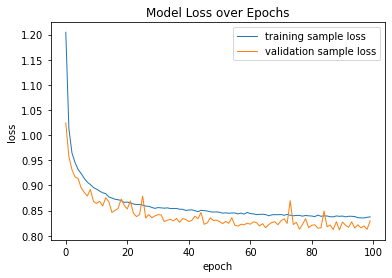

In [11]:
learningCurveLoss(history)

In [12]:
def makeRoc(features_val, labels_val, labels, model, outputSuffix=''):
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.title('%s ROC Curve'%(outputSuffix))
    #plt.savefig('%s_ROC_Curve.png'%(outputSuffix))
    return labels_pred

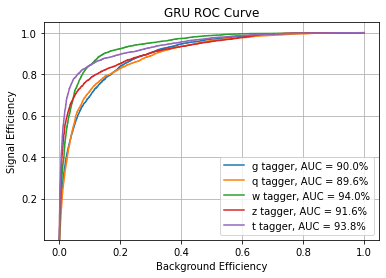

In [13]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='GRU')